In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp
from multiprocessing import Pool
import re
from collections import Counter
import time
import os
from functools import partial

In [2]:
l = os.listdir('RtMzInt_RAW/')
l = list(map(lambda x: re.match('(.*?)_[A-z\.]+', x)[1], l))
l = list(set(l))
os.system('mkdir CSVs')

256

In [3]:
def deco(fun):
    def wrapper(*args, **kwargs):
        s = time.time()
        results = fun(*args, **kwargs)
        print('run time:{1:.2f}'.format(time.time()-s))
        return results
    return wrapper

def process(data, fun, axis):
    return data.apply(fun, axis)

def best_number_of_processes(data):
    import multiprocessing as mp
    
    CPUs = mp.cpu_count()
    rows = data.shape[0]
    if rows < 10:
        return 2
    elif rows < 100:
        return 4
    else:
        return CPUs
    
def multiprocessing_apply(data, fun, processes=None, axis=1):
    from multiprocessing import Pool
    from functools import partial
    
    if not processes:
        processes = best_number_of_processes(data)
        
    with Pool(processes=processes) as pool:
        if data.isnull().sum().sum():
            print("There are NA")
        
        data = np.array_split(data, processes)
        data = pool.map(partial(process, fun=fun, axis=axis), data)
        
        return pd.concat(data)   
def multiprocessing_normal(data, fun, processes=None, axis=1):
    from multiprocessing import Pool
    from functools import partial

    if not processes:
        processes = best_number_of_processes(data)

    with Pool(processes=processes) as pool:
        data = np.array_split(data, processes)
        data = pool.map(fun, data)
        return pd.concat(data)

In [4]:
def todate(data):
    return pd.to_datetime(data, unit='s')
def tofloat(x):
    res = re.findall('"\d*"(.*?)\n', x)[0]
    res = round(float(res), 5)
    return res

In [5]:
def make_final(filename):
    mzs0 = open('RtMzInt_RAW/%s_mz.txt' % filename)
    ints0 = open('RtMzInt_RAW/%s_int.txt' % filename)
    rts0 = open('RtMzInt_RAW/%s_rt.csv' % filename)

    mzs = pd.DataFrame(mzs0.readlines()).rename({0: 'm/z'}, axis=1)
    ints = pd.DataFrame(ints0.readlines()).rename({0: 'intensity'}, axis=1)
    rts = pd.DataFrame(rts0.readlines()).drop(0).rename({0: 'rt'}, axis=1)

    mzs0.close()
    ints0.close()
    rts0.close()

    rts.index = mzs[mzs['m/z'].str.contains('x')].index
    df = pd.concat([mzs, ints], axis=1)
    df['index'] = rts
    df = df.fillna(method='ffill')
    df = df.drop(rts.index)
    df.index = df['index']
    df = df.drop('index', axis=1)
    df['rt_index'], df['rt'] = df.index.str.split(',').str
    df.index = np.arange(df.shape[0])
    df['rt_index'] = df['rt_index'].apply(lambda x: x.replace('"', ''))
    df['rt'] = multiprocessing_normal(df['rt'].apply(lambda x: float(x.strip())), todate)
    df['m/z'] = multiprocessing_apply(df['m/z'], tofloat)
    df['intensity'] = multiprocessing_apply(df['intensity'], tofloat)
    
    return df

def tocsv(res):
    df, filename = res
    df.to_csv('CSVs/%s.csv' % filename, index=None)

In [6]:
res = []
for filename in l:
    res.append([make_final(filename), filename])
    print('%s has done!' % filename)
    if len(res) >= 6 or filename==l[-1]:
        with Pool(processes=6) as pool:
            pool.map(tocsv, res)
            res = []

QC_2_3 has done!
QC_3_2 has done!
Sample_5_2 has done!
Sample_4_1 has done!
QC_4_3 has done!
QC_4_2 has done!
Sample_2_3 has done!
QC_3_3 has done!
Filter_05 has done!
Filter_03 has done!
Sample_4_3 has done!
Sample_1_1 has done!
Sample_5_1 has done!
Sample_1_2 has done!
Filter_075 has done!
Sample_2_1 has done!
Sample_2_2 has done!
Sample_4_2 has done!
QC_1_2 has done!
Sample_3_2 has done!
QC_2_2 has done!
QC_3_1 has done!
QC_4_1 has done!
Sample_3_3 has done!
QC_2_1 has done!
QC_1_3 has done!
Filter_01 has done!
Sample_5_3 has done!
QC_5_3 has done!
QC_5_1 has done!
Sample_1_3 has done!
Filter_1 has done!
QC_5_2 has done!
Sample_3_1 has done!
QC_1_1 has done!
Fiter_015 has done!


In [6]:
plt.style.use('bmh')

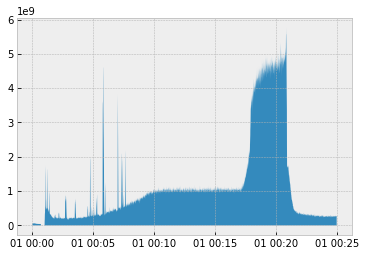

In [10]:
plt.fill_between(df.rt.unique(), df.groupby('rt_index')['intensity'].max())

In [35]:
c = Counter()
pivot = 0

while True:
    line = ints.readline()
    if not line:
        c[pivot] = max(c[pivot])
        break
    if 'x' in line:
        pivot += 1
        c[pivot] = []
        if pivot > 1:
            c[pivot-1] = max(c[pivot-1])
    else:
        c[pivot].append(round(float(re.findall('".*?" (.*)\n', line)[0]), 2))

AttributeError: 'DataFrame' object has no attribute 'readline'

In [241]:
c = Counter()
l = []
pivot = 0
while True:
    line = ints.readline()
    if not line:
        c[pivot] = sum(c[pivot])
        break
    if 'x' in line:
        pivot += 1
        c[pivot] = []
        if pivot > 1:
            c[pivot-1] = sum(c[pivot-1])
    else:
        c[pivot].append(round(float(re.findall('".*?" (.*)\n', line)[0]), 2))

In [21]:
plt.style.use('seaborn')

In [27]:
i = 0
r = []
while True:
    l = rts.readline()
    if not l: break
        
    if 'F' in l:
        r.append(round(float(re.findall('".*?",(.*)\n', l)[0]), 5))

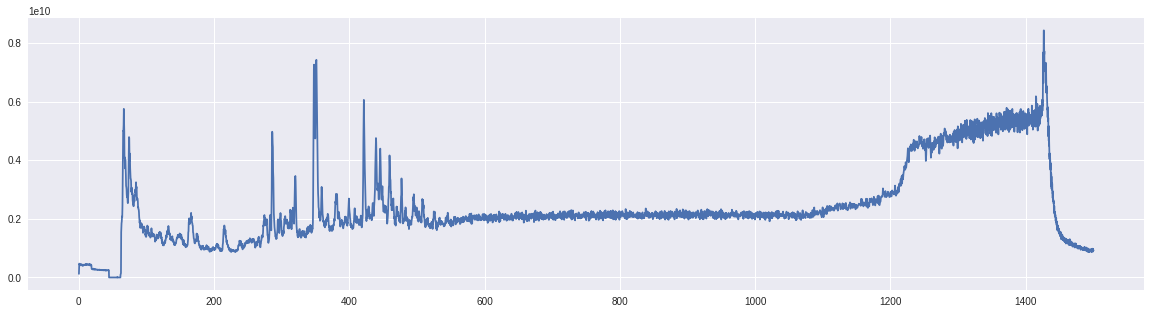

In [243]:
plt.style.use('seaborn')
plt.figure(figsize=(20,5))
plt.plot(r, list(zip(*c.items()))[1])

(0, 1500)

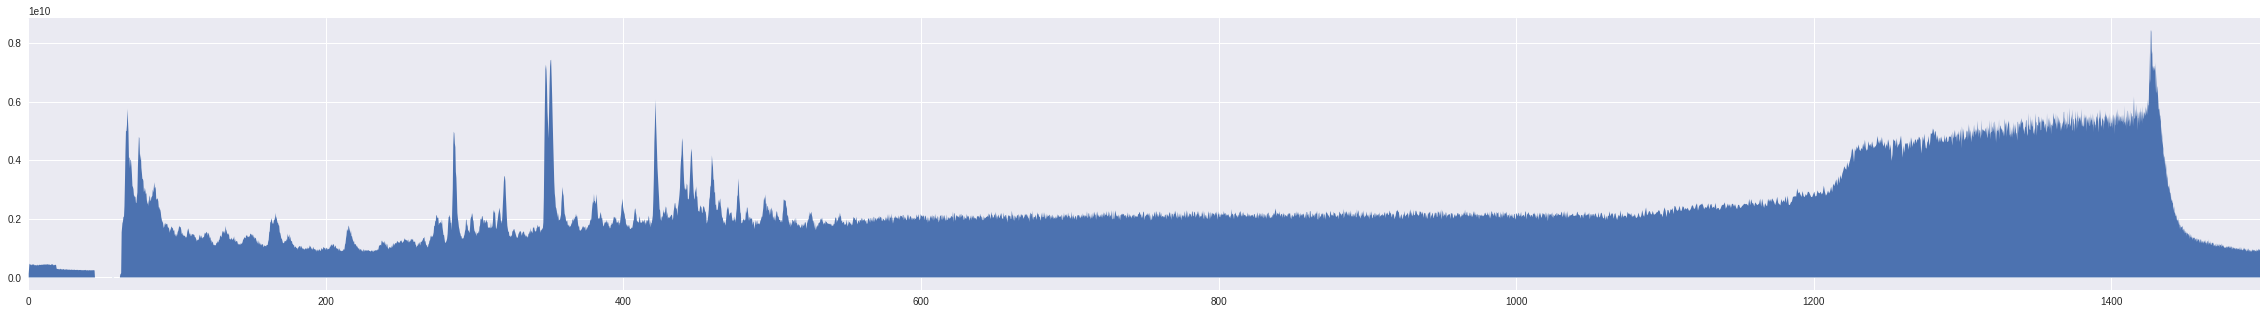

In [256]:
plt.style.use('seaborn')
plt.figure(figsize=(40,5))
plt.fill_between(r, list(zip(*c.items()))[1])
plt.xlim(0,1500)

(0, 1500)

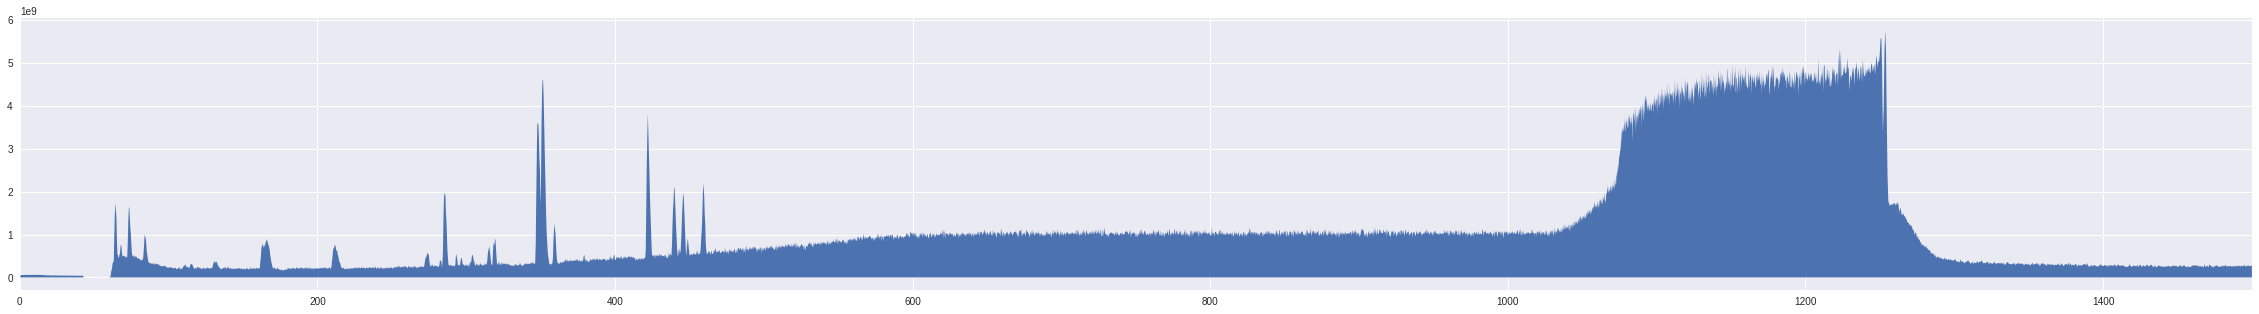

In [29]:
plt.style.use('seaborn')
plt.figure(figsize=(40,5))
plt.fill_between(r, list(zip(*c.items()))[1])
plt.xlim(0,1500)

In [68]:
df = pd.DataFrame(list(zip(*c.items()))[1],index=pd.to_datetime(r, unit='s'))

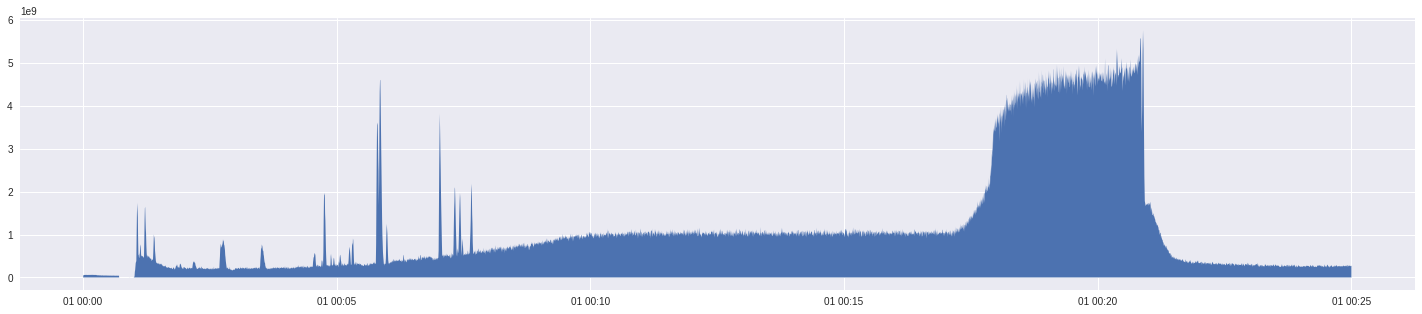

In [70]:
plt.figure(figsize=(25,5))
plt.fill_between(df.index, df[0])

In [71]:
index = df.index

In [73]:
index.second

Int64Index([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  2,
            ...
            53, 54, 55, 55, 56, 57, 57, 58, 59,  0],
           dtype='int64', length=4366)

In [72]:
index.minute

Int64Index([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
            ...
            24, 24, 24, 24, 24, 24, 24, 24, 24, 25],
           dtype='int64', length=4366)

(0, 5000000000.0)

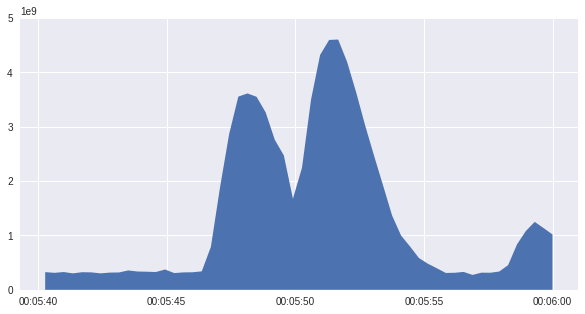

In [90]:
plt.figure(figsize=(10,5))
_ = df[(index > pd.to_datetime(340, unit='s')) & (index < pd.to_datetime(360, unit='s'))]
plt.fill_between(_.index, _[0])
plt.ylim(0,5e9)

(719163.0039351851, 719163.0041666667)

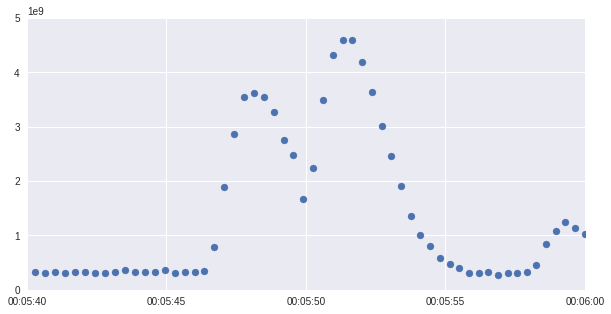

In [93]:
plt.figure(figsize=(10,5))
_ = df[(index > pd.to_datetime(340, unit='s')) & (index < pd.to_datetime(360, unit='s'))]
plt.scatter(_.index, _[0])
plt.ylim(0,5e9)
plt.xlim(pd.to_datetime(340, unit='s'), pd.to_datetime(360, unit='s'))